In [23]:
import pandas as pd
import xarray as xr
from pvlib import clearsky, atmosphere, solarposition

In [24]:
# Load the netCDF file
year = '2019'
df1 = xr.open_dataset('data/tasmax_W5E5v2.0_20110101-20191231.nc')
df2 = xr.open_dataset('data/tasmin_W5E5v2.0_20110101-20191231.nc')
df3 = xr.open_dataset('data/tas_W5E5v2.0_20110101-20191231.nc')
df4 = xr.open_dataset('data/rsds_W5E5v2.0_20110101-20191231.nc')
df1= df1.sel(time='2019')
df2= df2.sel(time='2019')
df3= df3.sel(time='2019')
df4= df4.sel(time='2019')
df = xr.merge([df1, df2,df3,df4])
df.head()

<xarray.Dataset>
Dimensions:  (lon: 5, lat: 5, time: 5)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 87.75
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-01-05
Data variables:
    tasmax   (time, lat, lon) float32 ...
    tasmin   (time, lat, lon) float32 ...
    tas      (time, lat, lon) float32 ...
    rsds     (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    title:        WFDE5 over land merged with ERA5 over the ocean (W5E5) vers...
    institution:  Potsdam Institute for Climate Impact Research (PIK)
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    summary:      WFDE5 (with GPCC precipitation correction) over land merged...
    references:   Cucchi et al. (2020) <https://doi.org/10.5194/essd-12-2097-...
    version:      2.0

In [25]:
df['rsds'] = df['rsds'] * 86.4/2264.7 # Convert to mm/day
df['tasmax'] = df['tasmax'] - 273.15 # Convert to C
df['tasmin'] = df['tasmin'] - 273.15 # Convert to C
df['tas'] = df['tas'] - 273.15 # Convert to C
df['etp'] = 0.0023 * (df.tas + 17.78) * df.rsds * (df.tasmax - df.tasmin)**0.5 

In [26]:
df['etp'].max()

<xarray.DataArray 'etp' ()>
array(9.025796, dtype=float32)

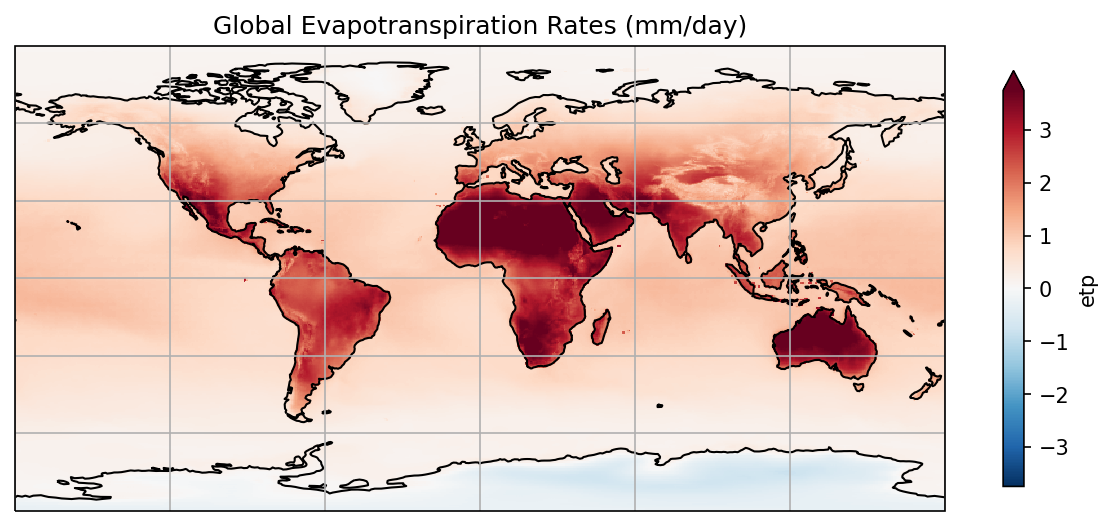

In [31]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming you have a dataset named 'evapotranspiration' with dimensions 'lat', 'lon', and 'time'

# Select a specific time slice (if necessary)
# evapotranspiration = evapotranspiration.sel(time='2019-01-01')

# Increase figure size and resolution
fig = plt.figure(figsize=(10, 6), dpi=150)

# Create a new axis with a PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the global map
df['etp'].mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(), robust=True,
                                         cbar_kwargs={'shrink': 0.6})

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Set plot title
plt.title('Global Evapotranspiration Rates (mm/day)')

# Save the figure
plt.savefig("figs/etp.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


In [ ]:
df = pd.read_csv('../output/w5e5_2019.csv', parse_dates=["time"])
df = df.set_index('time')
df.index.tz_localize(tz='Asia/Kolkata')
df

In [ ]:
tus = Location(34.216638,77.606949, 'Asia/Kolkata', 4009, 'Gangles')

times = pd.date_range(start=df.index.values[0], end=df.index.values[-1], freq='60min', tz=tus.tz)

cs = tus.get_clearsky(times)['ghi']  # ineichen with climatology table by default
cs = cs.tz_localize(None)
# Resample and aggregate results by day
cs = cs.resample('D').sum()/24
df['ghi'] = cs * 86.4/2264.7 # Convert to mm/day
df['etp'] = 0.0023 * (df.temp + 17.78) * df.ghi * (df.tempmax - df.tempmin)**0.5 
# Althoff, D.; Santos, R.A.d.; Bazame, H.C.; Cunha, F.F.d.; Filgueiras, R. Improvement of Hargreaves–Samani Reference Evapotranspiration Estimates with Local Calibration. Water 2019, 11, 2272. https://doi.org/10.3390/w11112272
df['etp'] /=1000 # Convert to m/day